# Import files, libraries, define path and initialize lists

In [1]:
!pip install kagglehub
from google.colab import files

import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [02:03<00:00, 23.5MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [25]:
import pandas as pd
import numpy as np
from PIL import Image
import glob
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import EfficientNetV2L

In [8]:
# Define the dataset path
root_folder = "/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"

data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

In [9]:
# Initialize lists
image_paths = []
species_labels = []
disease_labels = []
dataset_split = []

# Function to process a dataset directory
def process_directory(base_path, split_name):
    for class_folder in os.listdir(base_path):
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):
            species, disease = class_folder.split('___')
            for image_name in os.listdir(class_folder_path):
                image_paths.append(os.path.join(class_folder_path, image_name))
                species_labels.append(species)
                disease_labels.append(disease)
                dataset_split.append(split_name)

# Process train and valid
process_directory(train_path, 'train')
process_directory(valid_path, 'valid')

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'species': species_labels,
    'disease': disease_labels,
    'split': dataset_split
})

# MobileNetV2

In [10]:
# Define the image generators for the training and validation set
batch_size = 32
num_classes = 38
img_size = (256, 256)

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True)

# Import the MobileNetV2 model as a baseline
base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (256, 256, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
model_mbn = Sequential()
model_mbn.add(base_model)
model_mbn.add(GlobalAveragePooling2D())
model_mbn.add(Dense(1024, activation = "relu"))
model_mbn.add(Dropout(rate = 0.2))
model_mbn.add(Dense(512, activation = "relu"))
model_mbn.add(Dropout(rate = 0.2))
model_mbn.add(Dense(num_classes, activation = "softmax"))

# Compile the model
optimizer = Adam(learning_rate = 0.001)
model_mbn.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


<ipython-input-10-3cc6a7af1798>:25: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (256, 256, 3))


In [11]:
# Training the model
model_mbn.fit(
    train_generator,
    epochs = 3,
    validation_data = validation_generator
    )

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 137s 59ms/step - accuracy: 0.7959 - loss: 0.6807 - val_accuracy: 0.9392 - val_loss: 0.1878
Epoch 2/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 125s 57ms/step - accuracy: 0.9303 - loss: 0.2114 - val_accuracy: 0.9451 - val_loss: 0.1689
Epoch 3/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 124s 56ms/step - accuracy: 0.9434 - loss: 0.1687 - val_accuracy: 0.9530 - val_loss: 0.1476


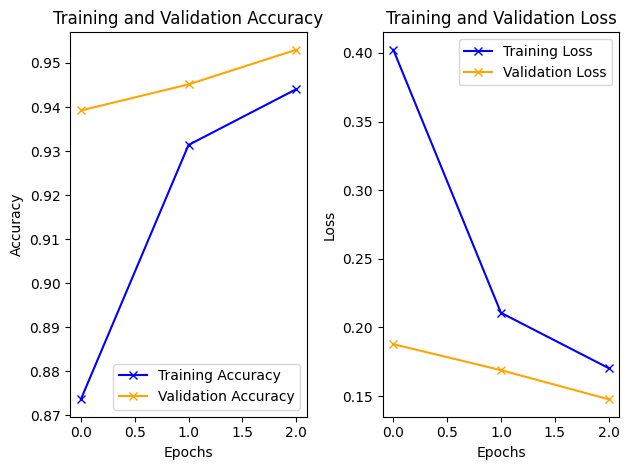

In [21]:
history = model_mbn.history

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='x')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='x')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ResNet 101

In [13]:
# Define the image generators for the training and validation set
batch_size = 32
num_classes = 38
img_size = (256, 256)

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

# Import the ResNet101 model as a baseline
base_model = ResNet101(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
model_rsn = Sequential()
model_rsn.add(base_model)
model_rsn.add(GlobalAveragePooling2D())
model_rsn.add(Dense(1024, activation="relu"))
model_rsn.add(Dropout(rate=0.2))
model_rsn.add(Dense(512, activation="relu"))
model_rsn.add(Dropout(rate=0.2))
model_rsn.add(Dense(num_classes, activation="softmax"))

# Compile the model
optimizer = Adam(learning_rate = 0.001)
model_rsn.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [14]:
# Training the model
model_rsn.fit(
    train_generator,
    epochs = 3,
    validation_data = validation_generator
    )

Epoch 1/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 512s 224ms/step - accuracy: 0.1101 - loss: 3.2029 - val_accuracy: 0.3079 - val_loss: 2.3881
Epoch 2/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 483s 220ms/step - accuracy: 0.2695 - loss: 2.4787 - val_accuracy: 0.3515 - val_loss: 2.1755
Epoch 3/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 483s 219ms/step - accuracy: 0.3218 - loss: 2.2726 - val_accuracy: 0.3915 - val_loss: 2.0420


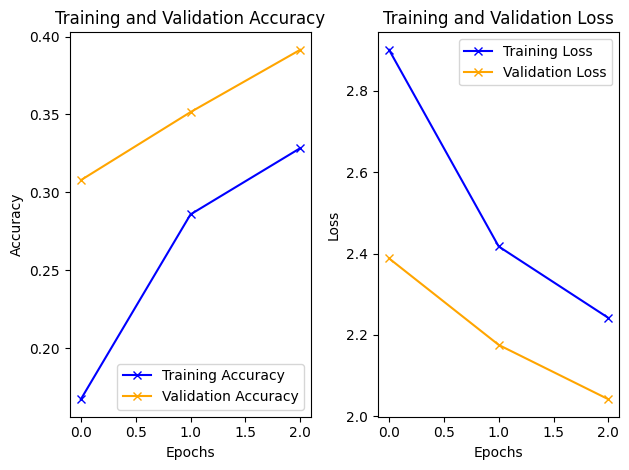

In [22]:
history = model_rsn.history

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='x')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='x')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# EfficientNetV2L

In [15]:
# Define the image generators for the training and validation set
batch_size = 32
num_classes = 38
img_size = (256, 256)

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

# Import the EfficientNetV2L model as the base
base_model = EfficientNetV2L(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
model_effn = Sequential()
model_effn.add(base_model)
model_effn.add(GlobalAveragePooling2D())
model_effn.add(Dense(1024, activation="relu"))
model_effn.add(Dropout(rate=0.2))
model_effn.add(Dense(512, activation="relu"))
model_effn.add(Dropout(rate=0.2))
model_effn.add(Dense(num_classes, activation="softmax"))

# Compile the model
optimizer = Adam(learning_rate = 0.001)
model_effn.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


In [17]:
# Training the model
model_effn.fit(
    train_generator,
    epochs = 3,
    validation_data = validation_generator
    )

Epoch 1/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1153s 483ms/step - accuracy: 0.0429 - loss: 3.5634 - val_accuracy: 0.1579 - val_loss: 3.0786
Epoch 2/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 993s 452ms/step - accuracy: 0.1020 - loss: 3.2333 - val_accuracy: 0.2087 - val_loss: 2.7937
Epoch 3/3
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 994s 452ms/step - accuracy: 0.1376 - loss: 3.0875 - val_accuracy: 0.2234 - val_loss: 2.7036


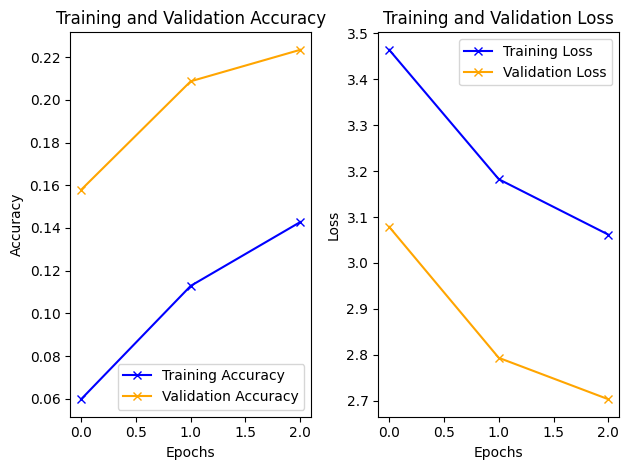

In [23]:
history = model_effn.history

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='x')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='x')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Summary

In [24]:
data = {
    "Model": ["MobileNetV2", "ResNet-101", "EfficientNetV2-L"],
    "Training Accuracy": [0.9434, 0.3218, 0.1376],
    "Validation Accuracy": [0.9530, 0.3915, 0.2234],
    "Training Loss": [0.1687, 2.2726, 3.0875],
    "Validation Loss": [0.1476, 2.0420, 2.7036]
}

# Create DataFrame
results_df = pd.DataFrame(data)
print(results_df)

              Model  Training Accuracy  Validation Accuracy  Training Loss  \
0       MobileNetV2             0.9434               0.9530         0.1687   
1        ResNet-101             0.3218               0.3915         2.2726   
2  EfficientNetV2-L             0.1376               0.2234         3.0875   

   Validation Loss  
0           0.1476  
1           2.0420  
2           2.7036  


In [26]:
# Generate predictions for validation data
y_true = validation_generator.classes  # True labels from the validation generator
y_pred_mbn = np.argmax(model_mbn.predict(validation_generator), axis=1)
y_pred_rsn = np.argmax(model_rsn.predict(validation_generator), axis=1)
y_pred_effn = np.argmax(model_effn.predict(validation_generator), axis=1)

# Create confusion matrices
conf_mtx_mbn = confusion_matrix(y_true, y_pred_mbn)
conf_mtx_rsn = confusion_matrix(y_true, y_pred_rsn)
conf_mtx_effn = confusion_matrix(y_true, y_pred_effn)

# Display classification reports
print("MobileNetV2 Classification Report")
print(classification_report(y_true, y_pred_mbn))

print("\nResNet-101 Classification Report")
print(classification_report(y_true, y_pred_rsn))

print("\nEfficientNetV2-L Classification Report")
print(classification_report(y_true, y_pred_effn))

550/550 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 100s 172ms/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 221s 370ms/step
MobileNetV2 Classification Report
              precision    recall  f1-score   support

           0       0.03      0.03      0.03       504
           1       0.03      0.03      0.03       497
           2       0.02      0.02      0.02       440
           3       0.03      0.03      0.03       502
           4       0.02      0.02      0.02       454
           5       0.03      0.03      0.03       421
           6       0.04      0.04      0.04       456
           7       0.02      0.02      0.02       410
           8       0.03      0.03      0.03       477
           9       0.02      0.02      0.02       477
          10       0.03      0.03      0.03       465
          11       0.02      0.02      0.02       472
          12       0.03      0.03      0.03       480
          13       0.03      0.03      0.03       430
          14       0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
